In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install transformers datasets evaluate -q
#!pip uninstall pyarrow
!pip install pyarrow
!pip install transformers[torch]
#y!pip uninstall accelerate
!pip install accelerate -U
!pip install peft

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
def read_json(path):
    with open(path,'r') as f:
        json_f = json.load(f)
        return json_f

In [ ]:
import os
import json
import matplotlib.pyplot as plt
from imageio import imread
import pandas as pd
from datasets import Dataset, DatasetDict

dict_list = []
path = '/content/drive/MyDrive/Colab Notebooks/SciCap-Caption-All/train'
file_names = os.listdir(path)
print(len(file_names))
for file_name in file_names:
    try:
        json_file = read_json(f'{path}/{file_name}')
        items = json_file.items()
        #print(items)
        image_path = "/content/drive/MyDrive/Colab Notebooks/SciCap-No-Subfig-Img/train/"+items.mapping.get('figure-ID')

        caption = items.mapping.get('2-normalized').items().mapping.get('2-2-advanced-euqation-bracket').items().mapping.get('caption')
        if(os.path.exists(image_path)):
           row_dict = {'FileName': image_path, 'Caption': caption}
           dict_list.append(row_dict)

    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")
        continue
print(len(dict_list))
df = pd.DataFrame(dict_list)
data_dict = {
    'FileName': df['FileName'].tolist(),
    'Caption':  df['Caption'].tolist()
}

dataset = Dataset.from_dict(data_dict)
dataset_dict = DatasetDict({
    'train': dataset
})
train_ds = dataset_dict['train']
train_ds

473
167


Dataset({
    features: ['FileName', 'Caption'],
    num_rows: 167
})

In [ ]:
dict_list = []
path = '/content/drive/MyDrive/Colab Notebooks/SciCap-Caption-All/val'
file_names = os.listdir(path)
print(len(file_names))
for file_name in file_names:
    try:
        json_file = read_json(f'{path}/{file_name}')
        items = json_file.items()
        #print(items)
        image_path = "/content/drive/MyDrive/Colab Notebooks/SciCap-No-Subfig-Img/val/"+items.mapping.get('figure-ID')
        caption = items.mapping.get('2-normalized').items().mapping.get('2-2-advanced-euqation-bracket').items().mapping.get('caption')
        if(os.path.exists(image_path)):
           row_dict = {'FileName': image_path, 'Caption': caption}
           dict_list.append(row_dict)

    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")
        continue
print(len(dict_list))
df = pd.DataFrame(dict_list)
data_dict = {
    'FileName': df['FileName'].tolist(),
    'Caption':  df['Caption'].tolist()
}

dataset = Dataset.from_dict(data_dict)
dataset_dict = DatasetDict({
    'val': dataset
})
val_ds = dataset_dict['val']
val_ds

483
7


Dataset({
    features: ['FileName', 'Caption'],
    num_rows: 7
})

In [ ]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)


In [ ]:
import sys
from PIL import Image
import numpy as np

reqimages = []
reqDict = dict()
for x in train_ds["FileName"]:
    try:
        f  = Image.open(x).getdata()
        reqimages.append(f)
    except Exception as e:
        continue
print(len(reqimages))
rgb_values = np.concatenate([img for img in reqimages], axis=0) / 255

#rgb_values = np.concatenate([Image.open(test_fig_id).getdata()], axis=0) / 255


# rgb_values.shape == (n, 3),
# where n is the total number of pixels in all images,
# and 3 are the 3 channels: R, G, B.

# Each value is in the interval [0; 1]

mu_rgb = np.mean(rgb_values, axis=0)  # mu_rgb.shape == (3,)
std_rgb = np.std(rgb_values, axis=0)  # std_rgb.shape == (3,)

print(mu_rgb)
print(std_rgb)

167
[0.96305279 0.95976804 0.96147718]
[0.1446056  0.14918483 0.14800113]


In [ ]:
from PIL import Image
#import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict

def transforms(example_batch):

    imgProcessor = processor.image_processor
    txtTokenizer = processor.tokenizer
    txtTokenizer.padding_side = "left"
    txtTokenizer.truncation_side = "left"

    imgProcessor.do_normalize
    # rgb_values.shape == (n, 3),
    # where n is the total number of pixels in all images,
    # and 3 are the 3 channels: R, G, B.

    # Each value is in the interval [0; 1]
    imagesarr = []
    captionsarr = []
    for file_name, caption in zip(example_batch["FileName"], example_batch["Caption"]):  # Iterate over file names and captions
        # Assuming file_name is a valid path or a file-like object
        image = Image.open(file_name)
        imagesarr.append(image)
        captionsarr.append(caption)
    imgProcessor.preprocess(images=imagesarr,image_mean=mu_rgb[:3], image_std=std_rgb[:3])

    inputs = processor(images=imagesarr, text=captionsarr, return_tensors="pt",padding=True, truncation=True)
    inputs.update({"labels": inputs["input_ids"]})
    print(type(inputs))
    return inputs


train_ds.set_transform(transforms)
#test_ds.set_transform(transforms)
val_ds.set_transform(transforms)

In [ ]:
print(train_ds.shape)
#print(test_ds.shape)
#print(test_ds[0])
print(val_ds.shape)

(167, 2)
(7, 2)


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model = AutoModelForCausalLM.from_pretrained(checkpoint)
# Load the tokenizer associated with the model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokens = items.mapping.get('2-normalized').items().mapping.get('2-2-advanced-euqation-bracket').items().mapping.get('tokens')
if isinstance(tokens, list):
    tokens = " ".join(tokens)  # Join list of tokens into a single string

# Tokenize the input text
inputs = tokenizer(tokens, return_tensors="pt")

# Get the input IDs
input_ids = inputs["input_ids"]

# Forward pass
#model.forward(input_ids=input_ids, pixel_values=torch.randn(1, 3, 224, 224))


#model_config = model.config
#model_config.
#print(model.config)


In [ ]:
!pip install jiwer
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [ ]:
#!pip uninstall peft
#!pip install peft

from peft import LoraConfig, TaskType, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GitForCausalLM
import inspect

target_modules = ["q_proj", "v_proj"]  # Example target modules, adjust as needed

peft_config = LoraConfig(task_type=TaskType.FEATURE_EXTRACTION, inference_mode=False, r=8,
                         lora_alpha=32, lora_dropout=0.1, target_modules=target_modules)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


#model.add_adapter(lora_config)

trainable params: 294,912 || all params: 176,913,978 || trainable%: 0.1667


In [ ]:
#!pip uninstall transformers[torch]

from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-scicap",
    learning_rate=5e-5,
    num_train_epochs=5,
    fp16=True,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from torch.nn import CrossEntropyLoss

def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.pop("labels")  # Remove labels from inputs as they are not model inputs
    outputs = model(**inputs)  # Forward pass
    logits = outputs.logits
    loss_fct = CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

print(len(train_ds))
print(len(val_ds))

167
7


In [ ]:
print(trainer.label_names)
trainer.train()

['labels']


Unused or unrecognized kwargs: padding, truncation.


<class 'transformers.tokenization_utils_base.BatchEncoding'>


Unused or unrecognized kwargs: padding, truncation.


<class 'transformers.tokenization_utils_base.BatchEncoding'>


Unused or unrecognized kwargs: padding, truncation.


<class 'transformers.tokenization_utils_base.BatchEncoding'>


Step,Training Loss,Validation Loss


Unused or unrecognized kwargs: padding, truncation.


<class 'transformers.tokenization_utils_base.BatchEncoding'>


KeyboardInterrupt: 

In [ ]:
#trainer.push_to_hub()

In [ ]:
# Save the model
trainer.save_model(training_args.output_dir)

# Save the tokenizer
processor.save_pretrained(training_args.output_dir)

[]

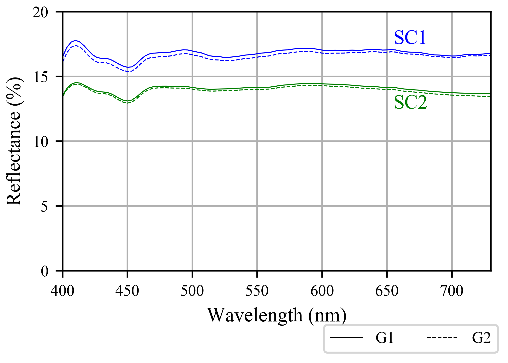

In [ ]:
from PIL import Image
import requests

#print (test_ds[0])
url = '/content/drive/MyDrive/Colab Notebooks/SciCap-No-Subfig-Img/val/2011.10028v1-Figure5-1.png'
image = Image.open(url)
image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


a plot of the plot of the line.
